<h1 style="color: #2c3f51"> Paddy Doctor: Paddy Disease Classification </h1>

Learn to use modern deep-learning networks to build an **image classifier** with Keras.

### Problem Statement
Rice (Oryza sativa) is one of the staple foods worldwide. Paddy, the raw grain before removal of husk, is cultivated in tropical climates, mainly in Asian countries. Paddy cultivation requires consistent supervision because several diseases and pests might affect the paddy crops, leading to up to 70% yield loss. Expert supervision is usually necessary to mitigate these diseases and prevent crop loss. With the limited availability of crop protection experts, manual disease diagnosis is tedious and expensive. Thus, it is increasingly important to automate the disease identification process by leveraging computer vision-based techniques that achieved promising results in various domains.

### Objective
The main objective of this competition is to develop a machine or deep learning-based model to classify the given paddy leaf images accurately. We provide a training dataset of 10,407 (75%) labeled images across ten classes (nine disease categories and normal leaf). Moreover, we also provide additional metadata for each image, such as the paddy variety and age. Your task is to classify each paddy image in the given test dataset of 3,469 (25%) images into one of the nine disease categories or a normal leaf.

Source : [competition website](https://www.kaggle.com/competitions/paddy-disease-classification/overview/description)

<center>
    <h2 style="color: #2c3f51"> 🏃🏻 Let's identify the type of disease present in paddy leaf images </h2>

### Imports

In [1]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

import tensorflow as tf
from tensorflow import keras

import matplotlib.pyplot as plt

import os, warnings

# Config

In [2]:
batch_size = 16
img_dim = 128
RESCALE = 1.0/255

VALIDATION_SPLIT = 0.1
SEED = 42

warnings.filterwarnings("ignore") # to clean up output cells

# Load Data

In [3]:
# Get training data path
train_dir = '../input/paddy-disease-classification/train_images/'

Let's going to do image preprocessing with **ImageDataGenerator** 

[Doc here](https://www.tensorflow.org/api_docs/python/tf/keras/preprocessing/image/ImageDataGenerator)

In [4]:
img_datagen = keras.preprocessing.image.ImageDataGenerator(
    rescale=RESCALE,                    # we multiply the data by the value provided (after applying all other transformations).
    validation_split=VALIDATION_SPLIT,  # Float. Fraction of images reserved for validation (strictly between 0 and 1).
    rotation_range=5,                   # Int. Degree range for random rotations.
    shear_range=0.3,                    # Float. Shear Intensity (Shear angle in counter-clockwise direction in degrees)
    zoom_range=0.3,                     # Float or [lower, upper]. Range for random zoom.
    width_shift_range=0.05,             # Float, 1-D array-like or int
    height_shift_range=0.05,            # Float, 1-D array-like or int
    horizontal_flip=True,               # Boolean. Randomly flip inputs horizontally.
    vertical_flip=True,                 # Boolean. Randomly flip inputs vertically.
)

In [5]:
# Define train data
ds_train = img_datagen.flow_from_directory(
    train_dir,
    subset="training",
    seed=SEED,
    shuffle=True,                    # Set True if you want to shuffle the order of the image that is being yielded, else set False.
    target_size=(img_dim, img_dim),  # Size of your input images, every image will be resized to this size.
    batch_size=batch_size,           # No. of images to be yielded from the generator per batch.
    class_mode="categorical",        # Set “binary” if you have only two classes to predict, if not set to“categorical”
)

Found 9371 images belonging to 10 classes.


In [6]:
# Define validation data
ds_valid = img_datagen.flow_from_directory(
    train_dir,
    subset="validation",
    seed=SEED,
    shuffle=False,
    target_size=(img_dim, img_dim),
    batch_size=batch_size,
    class_mode="categorical",
)

Found 1036 images belonging to 10 classes.


In [7]:
print(ds_train.class_indices)
OUTPUT_SIZE = len(ds_train.class_indices)

print("\n We have", OUTPUT_SIZE, " differents class")

{'bacterial_leaf_blight': 0, 'bacterial_leaf_streak': 1, 'bacterial_panicle_blight': 2, 'blast': 3, 'brown_spot': 4, 'dead_heart': 5, 'downy_mildew': 6, 'hispa': 7, 'normal': 8, 'tungro': 9}

 We have 10  differents class


# Modeling (with keras)

Now, we are going to build our model. Let's use :

- The **Conv2D** : to create a convolution kernel that is convolved with the layer input to produce a tensor of outputs. [more](https://keras.io/api/layers/convolution_layers/convolution2d/)

- The **MaxPooling2D** : downsamples the input along its spatial dimensions (height and width). [more](https://keras.io/api/layers/pooling_layers/max_pooling2d/)

- The **Flatten** layer : to transform the two dimensional outputs of the base into the one dimensional inputs needed by the head. [more](https://www.kaggle.com/code/ryanholbrook/the-convolutional-classifier)

In [8]:
from tensorflow.keras import layers

model = keras.Sequential([
    layers.InputLayer(input_shape=(img_dim, img_dim, 3)),
    layers.Conv2D(16, (3,3), activation='selu' ),
    layers.MaxPooling2D(2, 2),
    layers.Conv2D(32, (3,3), activation='selu'),
    layers.MaxPooling2D(2,2),
    layers.Conv2D(64, (3,3), activation='selu'),
    layers.MaxPooling2D(2,2),
    layers.Conv2D(128, (3,3), activation='selu'),
    layers.MaxPooling2D(2,2),
    layers.Flatten(),
    layers.Dense(2048, activation='selu'),
    layers.Dense(1024, activation='selu'),
    layers.Dense(256, activation='selu'),
    layers.Dense(128, activation='selu'),
    layers.Dense(OUTPUT_SIZE, activation='softmax')
])

# Prints a string summary of the network.
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 126, 126, 16)      448       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 63, 63, 16)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 61, 61, 32)        4640      
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 30, 30, 32)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 28, 28, 64)        18496     
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 14, 14, 64)        0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 12, 12, 128)       7

2022-05-24 15:43:01.902203: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-05-24 15:43:02.029534: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-05-24 15:43:02.030302: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-05-24 15:43:02.031590: I tensorflow/core/platform/cpu_feature_guard.cc:142] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compil

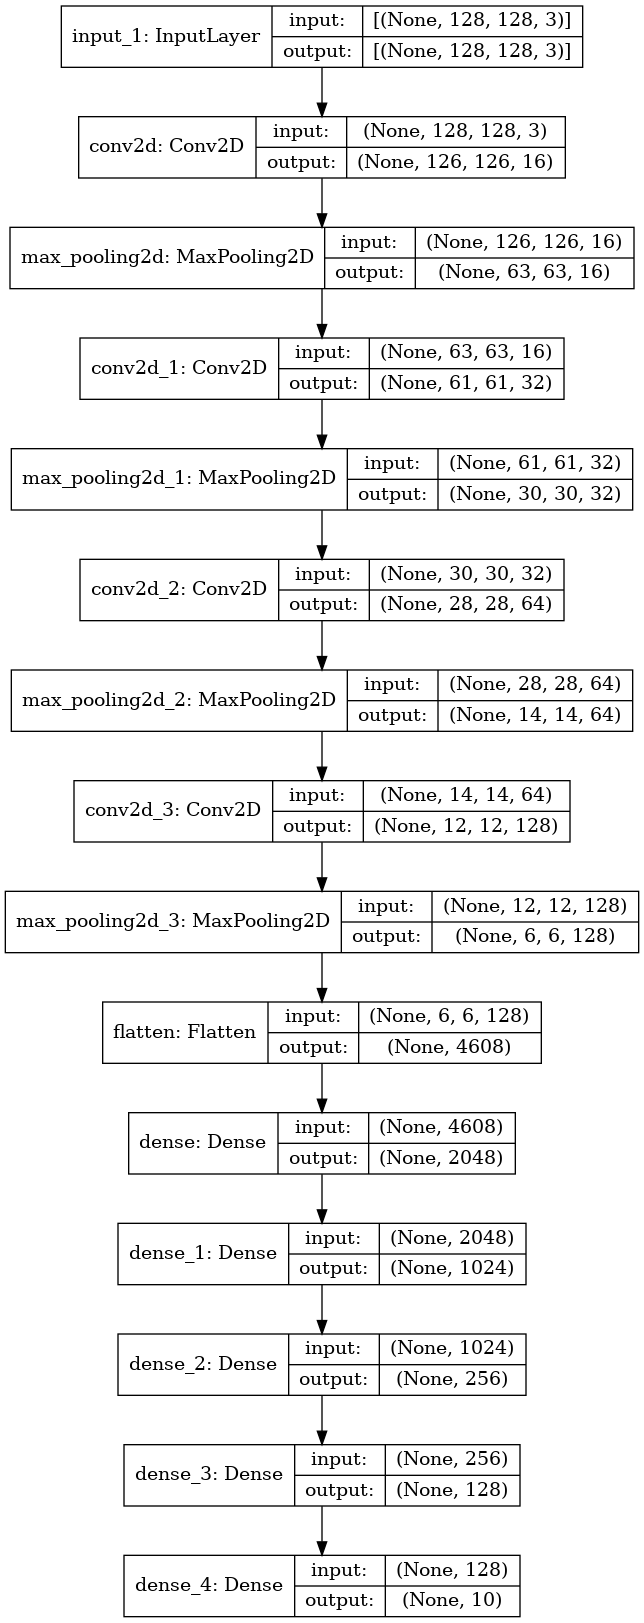

In [9]:
# To plot the model architecture
keras.utils.plot_model(model, to_file='model.png', expand_nested=True, show_shapes=True)

### Callbacks

Let's define the callbacks : EarlyStopping & ReduceLROnPlateau.

- The **EarlyStopping** : stop training when a monitored metric has stopped improving. [more](https://keras.io/api/callbacks/early_stopping/)

- The **ReduceLROnPlateau** : reduce learning rate when a metric has stopped improving. [more](https://keras.io/api/callbacks/reduce_lr_on_plateau/)


In [10]:
early_stopping_callback = keras.callbacks.EarlyStopping(monitor='val_loss', #Quantity to be monitored.
                            min_delta=0, #Minimum change in the monitored quantity to qualify as an improvement
                            patience=5,  #Number of epochs with no improvement after which training will be stopped.
                            verbose=0,   #Verbosity mode 0 is silent, and mode 1 displays messages
                            mode='auto') # in "auto" mode, the direction is automatically inferred from the name of the monitored quantity.

lr_reducer = keras.callbacks.ReduceLROnPlateau(monitor='val_loss', #quantity to be monitored.
                            factor=0.7, #factor by which the learning rate will be reduced. new_lr = lr * factor.
                            patience=5) #number of epochs with no improvement after which learning rate will be reduced.

callbacks = [early_stopping_callback, lr_reducer]

### Training
Finally, let's train the model. Since this is a ten class problem, we'll use the *Categorical* versions of crossentropy and accuracy. The adam optimizer generally performs well, so we'll choose it as well.

We are going to try to use GPU.

In [11]:
EPOCHS = 150

with tf.device(tf.test.gpu_device_name()):
    model.compile(
        optimizer=keras.optimizers.Adam(learning_rate=135e-6), # Optimizer
        # Loss function to minimize
        loss=keras.losses.CategoricalCrossentropy(),
        # List of metrics to monitor
        metrics=[keras.metrics.Accuracy()]
    )
    
    history = model.fit(
        ds_train,
        epochs = EPOCHS,
        validation_data = ds_valid,
        callbacks = callbacks,
        verbose = 1,
    )

2022-05-24 15:43:06.134499: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-05-24 15:43:06.135019: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-05-24 15:43:06.135387: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-05-24 15:43:06.135776: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-05-24 15:43:06.136163: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from S

Epoch 1/150


2022-05-24 15:43:08.509808: I tensorflow/stream_executor/cuda/cuda_dnn.cc:369] Loaded cuDNN version 8005


586/586 [==============================] - 156s 252ms/step - loss: 2.0803 - accuracy: 0.0000e+00 - val_loss: 1.8743 - val_accuracy: 0.0000e+00
Epoch 2/150
586/586 [==============================] - 106s 181ms/step - loss: 1.7189 - accuracy: 0.0000e+00 - val_loss: 1.6194 - val_accuracy: 0.0000e+00
Epoch 3/150
586/586 [==============================] - 100s 170ms/step - loss: 1.5641 - accuracy: 0.0000e+00 - val_loss: 1.4800 - val_accuracy: 0.0000e+00
Epoch 4/150
586/586 [==============================] - 100s 170ms/step - loss: 1.4136 - accuracy: 0.0000e+00 - val_loss: 1.3133 - val_accuracy: 0.0000e+00
Epoch 5/150
586/586 [==============================] - 100s 170ms/step - loss: 1.3025 - accuracy: 0.0000e+00 - val_loss: 1.3083 - val_accuracy: 0.0000e+00
Epoch 6/150
586/586 [==============================] - 101s 172ms/step - loss: 1.1903 - accuracy: 0.0000e+00 - val_loss: 1.2841 - val_accuracy: 0.0000e+00
Epoch 7/150
586/586 [==============================] - 101s 173ms/step - loss: 1.1

Now, we are going to examine the loss and metric plots.

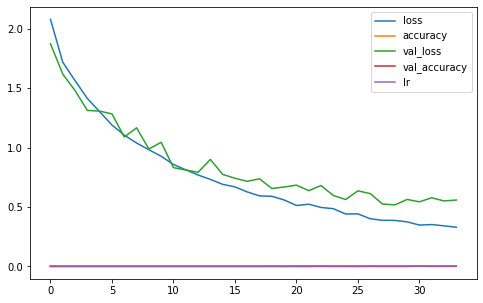

In [12]:
pd.DataFrame(history.history).plot(figsize=(8,5))
plt.show()

# Test Predictions

In [13]:
# Define test data
test_path = '../input/paddy-disease-classification/test_images'
ds_test = keras.preprocessing.image.ImageDataGenerator(rescale=RESCALE).flow_from_directory(    
    directory=test_path,
    target_size=(img_dim, img_dim),
    batch_size=batch_size,
    classes=['.'],
    shuffle=False,
)

Found 3469 images belonging to 1 classes.


In [14]:
# Prediction 
predict = model.predict(ds_test, verbose=1)

217/217 [==============================] - 37s 170ms/step


In [15]:
predicted_class_indices = np.argmax(predict,axis=1)
print(set(predicted_class_indices))

inv_map = {v:k for k,v in ds_train.class_indices.items()}

predictions = [inv_map[k] for k in predicted_class_indices]

{0, 1, 2, 3, 4, 5, 6, 7, 8, 9}


# Submission

In [16]:
filenames = ds_test.filenames

submission = pd.DataFrame({ "image_id":filenames, "label":predictions })

submission.image_id = submission.image_id.str.replace('./', '')
submission.to_csv("submission.csv",index=False)
submission.head()

,image_id,label
0,200001.jpg,normal
1,200002.jpg,normal
2,200003.jpg,normal
3,200004.jpg,tungro
4,200005.jpg,blast


In [17]:
submission['label'].value_counts()

blast                       824
normal                      708
dead_heart                  441
hispa                       373
tungro                      307
bacterial_leaf_streak       239
brown_spot                  212
downy_mildew                170
bacterial_leaf_blight       126
bacterial_panicle_blight     69
Name: label, dtype: int64

# Acknowledgements

We acknowledge the [Paddy Doctor](https://paddydoc.github.io/) project team at the Department of Computer Science and Engineering, Manonmaniam Sundaranar University, Tirunelveli, India, and its collaborators.

# Ressources 


- Kaggle course on [computer vision](https://www.kaggle.com/learn/computer-vision)
- keras [documentation](https://keras.io/)
- ImageDataGenerator [documentation](https://www.tensorflow.org/api_docs/python/tf/keras/preprocessing/image/ImageDataGenerator)
- @maifeeulasad [work](https://www.kaggle.com/code/maifeeulasad/paddy-doctor-paddy-disease-classification)



<h5 style="color: #c03100"> If you find this notebook useful, you can support with an upvote 🤗

<center>
    <h2 style="color: #2c3f51"> Thanks for reading 🙂 </h2>